# MySafetyNet

### Setup

In [1]:
# Check GPU
! nvidia-smi

Sat Oct 15 12:37:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install tflite-model-maker

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 577 kB 20.8 MB/s 
     |████████████████████████████████| 1.3 MB 54.4 MB/s 
     |████████████████████████████████| 1.1 MB 66.2 MB/s 
     |████████████████████████████████| 10.9 MB 67.9 MB/s 
     |████████████████████████████████| 840 kB 48.9 MB/s 
     |████████████████████████████████| 77 kB 7.7 MB/s 
     |████████████████████████████████| 60.2 MB 1.2 MB/s 
     |████████████████████████████████| 128 kB 70.5 MB/s 
     |████████████████████████████████| 87 kB 7.8 MB/s 
     |████████████████████████████████| 3.4 MB 52.8 MB/s 
     |████████████████████████████████| 238 kB 72.0 MB/s 
     |████████████████████████████████| 25.3 MB 1.2 MB/s 
     |████████████████████████████████| 497.9 MB 32 kB/s 
     |████████████████████████████████| 352 kB 66.5 MB/s 
     |████████████████████████████████| 99 kB 11.9 MB/s 
     |█████████████████████████████

In [15]:
import numpy as np
import pandas as pd
import os

from tflite_model_maker import model_spec
from tflite_model_maker import text_classifier
from tflite_model_maker.text_classifier import DataLoader
from tflite_support import metadata as _metadata

import tensorflow as tf

from sklearn.model_selection import train_test_split
print(tf.__version__)

2.8.3


### Load data with pandas

                                                    text  label
0      just had a real good moment. i missssssssss hi...      0
1             is reading manga  http://plurk.com/p/mzp1e      0
2      @comeagainjen http://twitpic.com/2y2lx - http:...      0
3      @lapcat Need to send 'em to my accountant tomo...      0
4          ADD ME ON MYSPACE!!!  myspace.com/LookThunder      0
...                                                  ...    ...
10309  No Depression by G Herbo is my mood from now o...      1
10310  What do you do when depression succumbs the br...      1
10311  Ketamine Nasal Spray Shows Promise Against Dep...      1
10312  dont mistake a bad day with depression! everyo...      1
10313                                                  0      1

[10314 rows x 2 columns]
Index(['text', 'label'], dtype='object')


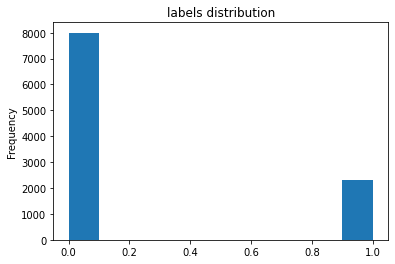

In [3]:
df = pd.read_csv('/content/sentiment_tweets3_pp.zip',
                 compression='zip',low_memory=False)
print(df)
print(df.keys())
df.label.plot(kind='hist', title='labels distribution')

### Split data

In [4]:
train_df, rest = train_test_split(df, random_state=42, train_size=0.80, stratify=df.label.values)
valid_df, test_df = train_test_split(rest, random_state=42, train_size=0.50, stratify=rest.label.values)
train_df.shape, valid_df.shape, test_df.shape

((8251, 2), (1031, 2), (1032, 2))

### Save data to csv

In [6]:
train_path = '/content/train_strat.csv'
valid_path = '/content/valid_strat.csv'
test_path = '/content/test_strat.csv'
train_df.to_csv (train_path, index = False, header=True)
valid_df.to_csv (valid_path, index = False, header=True)
test_df.to_csv (test_path, index = False, header=True)

### Load model

In [7]:
# classification model architecture
mb_spec = model_spec.get('mobilebert_classifier')
# model_spec object represents a model for the text classifier

### Load data with tensorflow

In [8]:

train_data_strat = DataLoader.from_csv(
      filename='/content/train_strat.csv',
      text_column='text',
      label_column='label',
      model_spec=mb_spec,
      is_training=True)

valid_data_strat = DataLoader.from_csv(
      filename='/content/valid_strat.csv',
      text_column='text',
      label_column='label',
      model_spec=mb_spec,
      is_training=True)

test_data_strat = DataLoader.from_csv(
      filename='/content/test_strat.csv',
      text_column='text',
      label_column='label',
      model_spec=mb_spec,
      is_training=True)


### Train model

In [9]:
model = text_classifier.create(train_data_strat, model_spec=mb_spec,validation_data=valid_data_strat, epochs=3)

171/171 [==============================] - 134s 468ms/step - loss: 0.6949 - test_accuracy: 0.8452 - val_loss: 0.0271 - val_test_accuracy: 0.9971
Epoch 2/2
171/171 [==============================] - 83s 469ms/step - loss: 0.0122 - test_accuracy: 0.9976 - val_loss: 0.0017 - val_test_accuracy: 0.9990
Epoch 3/3
171/171 [==============================] - 81s 463ms/step - loss: 0.0031 - test_accuracy: 0.9991 - val_loss: 4.4177e-04 - val_test_accuracy: 1.0000


In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 128)]        0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 hub_keras_layer_v1v2 (HubKeras  (None, 512)         24581888    ['input_word_ids[0][0]',         
 LayerV1V2)                                                       'input_mask[0][0]',         

### Test model

In [11]:
loss, acc = model.evaluate(test_data_strat)

33/33 [==============================] - 4s 112ms/step - loss: 0.0035 - test_accuracy: 0.9990


### Export TFLite model

In [12]:
model.export(export_dir='/content/mobilebert/')

In [ ]:
# check if swift requires more files e.g. label and vocab file (already embeded as metadata in .tflite)
# model.export(export_dir='/content/mobilebert', export_format=[ExportFormat.LABEL, ExportFormat.VOCAB])

### QUANTIZATION?
default quantization is already performed by model maker library when exporting the model. Maybe consider customize it

### Evaluation of TFLite model

In [14]:
accuracy = model.evaluate_tflite('/content/mobilebert/model.tflite', test_data_strat)
print('TFLite model accuracy: ', accuracy)

TFLite model accuracy:  {'accuracy': 0.999031007751938}


### Visualize metadata

In [24]:
export_model_path='/content/mobilebert/model.tflite'
displayer = _metadata.MetadataDisplayer.with_model_file(export_model_path)
print(displayer)
export_json_file = os.path.join('/content/mobilebert/model.json')
json_file = displayer.get_metadata_json()
print(json_file)

with open(export_json_file, "w") as f:
  f.write(json_file)

{
  "name": "MobileBert text classifier",
  "description": "Classifies the input string based on the known catergories. To integrate the model into your app, try the `BertNLClassifier` API in the TensorFlow Lite Task library. `BertNLClassifier` takes an input string, and returns the classified label with probability. It encapsulates the processing logic of inputs and outputs and runs the inference with the best practice.",
  "version": "v1",
  "subgraph_metadata": [
    {
      "input_tensor_metadata": [
        {
          "name": "ids",
          "description": "Tokenized ids of input text.",
          "content": {
            "content_properties_type": "FeatureProperties",
            "content_properties": {
            }
          }
        },
        {
          "name": "segment_ids",
          "description": "0 for the first sequence, 1 for the second sequence if exists.",
          "content": {
            "content_properties_type": "FeatureProperties",
            "content_prop